# Electrode Demo: 
For the nEXO project, we have a pair of electrodes that induce a strong electric field in a liquid xenon time projection chamber. The main challenge we face are electric glitches, which cause charge breakdowns in the liquid xenon and overwhelm the SIPM and charge sensors. These glitches seem to melt the surface of the electrodes, removing the gold surface and warping the steel underneath. I analyze the electrode images in two steps: first to find the area of the circle (the scope), and then to find the area of the gold surface left unscathed by glitches. The first step can be done with Hough Circles or findContour, and the second step is done with inRange and findContour.

In [68]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

**First**, I load the source image with imread. I retrieve the correct colorspace (RGB) and convert it into grayscale. I isolate the circle edge with a binary threshold and canny. The gaussian blur is necessary for Hough Circles.

Text(0.5, 1.0, 'Binary Threshold: alpha')

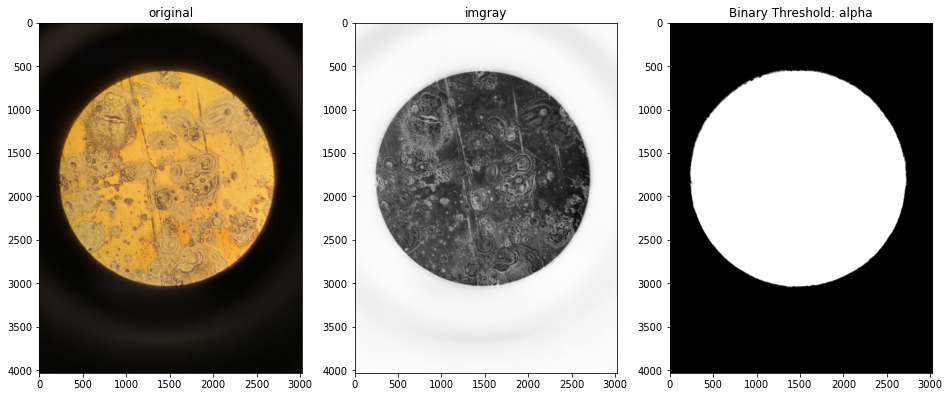

In [69]:
src = cv2.imread('Gold Set 2/y4_x12.JPG')
original = cv2.cvtColor(src, cv2.COLOR_BGR2RGB)
imgray = cv2.cvtColor(original,cv2.COLOR_BGR2GRAY)
_,alpha = cv2.threshold(imgray,55,255,cv2.THRESH_BINARY_INV)
alpha = cv2.GaussianBlur(alpha, (21,21), cv2.BORDER_DEFAULT)
#edges = cv2.Canny(alpha, 200, 255)


rows = 1
columns = 3
fig = plt.figure(figsize=(16,16))
fig.add_subplot(rows, columns, 1)
plt.imshow(original)
plt.title("original")
fig.add_subplot(rows, columns, 2)
plt.imshow(imgray, cmap='Greys')
plt.title("imgray")
fig.add_subplot(rows, columns, 3)
plt.imshow(alpha, cmap='Greys')
plt.title("Binary Threshold: alpha")
#fig.add_subplot(rows, columns, 4)
#plt.imshow(edges, cmap='Greys')
#plt.title("edges threshold")



The first way to find the properties of the circle is with Hough Circles. This method easily retrieves the center and the radius, but I ultimately decided to use findContour instead. My end goal is to find the ratio of areas, and thus I need the same method of calculating area for both the circle and the gold. Otherwise, a small error is introduced.

circle_contour, _ = cv2.findContours(alpha, cv2.RETR_TREE, 1)
print(len(circle_contour))
cc_area = 0
for c in circle_contour:
    curr_area = cv2.contourArea(c)
    if curr_area>cc_area:
        cc_area = curr_area
    cv2.drawContours(original, c, 0, (0,255,0), 100)
    
fig = plt.figure(figsize=(16,9))
plt.imshow(original)
print('Circle Area = ' + str(cc_area))

In [73]:
hough_circle = cv2.HoughCircles(alpha, cv2.HOUGH_GRADIENT, 1.5, 100, param1=50,param2=30,minRadius=0,maxRadius=0)
print('I have found ' + str(len(hough_circle)) + ' circle(s).')
hough_circle = np.round(hough_circle[0, 0,:])
(x,y) = (int(hough_circle[0]), int(hough_circle[1]))
r = int(hough_circle[2])
hc_area = np.pi*r**2
print('Center at (' + str(x) +', '+ str(y) + ')')
print('Radius = '+str(r))
print('Circle Area = ' + str(hc_area))

I have found 1 circle(s).
Center at (1474, 1798)
Radius = 1239
Circle Area = 4822724.855971416


In [ ]:
circlemask = np.zeros(original.shape, dtype=np.uint8)
cv2.circle(circlemask, (x,y), r, (255,255,255), -1)
circlemask = cv2.cvtColor(circlemask,cv2.COLOR_BGR2GRAY)
ROI = cv2.bitwise_and(original,original, mask=circlemask)

In [ ]:
rows = 1
columns = 4
fig = plt.figure(figsize=(16,9))
fig.add_subplot(rows, columns, 1)
plt.imshow(ROI)
plt.title("ROI")

hsvimage = cv2.cvtColor(ROI, cv2.COLOR_RGB2HSV)
lower = np.array([17, 137, 200], dtype="uint8")
upper = np.array([50, 190, 255], dtype="uint8")
goldmask = cv2.inRange(hsvimage, lower, upper)

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
opening = cv2.morphologyEx(goldmask, cv2.MORPH_OPEN, kernel, iterations=1)

cnts = cv2.findContours(opening, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
cnt_area = 0
for c in cnts:
    currcontour = cv2.contourArea(c)
    if currcontour >= 2000:
        cnt_area += currcontour
        cv2.drawContours(ROI,[c], 0, (0,0,255), 2)
print('The contour area is ' + str(cnt_area))

fig.add_subplot(rows, columns, 2)
plt.imshow(goldmask, cmap='Greys')
plt.title("Gold Mask")
fig.add_subplot(rows, columns, 3)
plt.imshow(opening, cmap='Greys')
plt.title("Processed")
fig.add_subplot(rows, columns, 4)
plt.imshow(ROI)
plt.title("ROI Contour")

In [ ]:
fig = plt.figure(figsize=(24,16))
cv2.circle(ROI, (x,y),r,(0,255,0), 5)
plt.imshow(ROI)

In [ ]:
#Calculating Area:
number_of_black_pix = np.sum(opening == 0)      # extracting only black pixels
print('Number of black pixels: ' + str(number_of_black_pix))
perarea = cnt_area/hc_area
print('Contour area/Circle area = '+ str(cnt_area)+'/'+ str(hc_area)+' = ' +str(perarea))
if perarea > 1:
    perarea = 1 
print(perarea)

In [ ]:
hsvalue = cv2.cvtColor(np.uint8([[[210,172,99]]]),cv2.COLOR_RGB2HSV)
print(str(hsvalue))